# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheetname=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheetname=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [4]:
#your turn
#merge data frames
df = df_offers.merge(df_transactions)
print(df.head())
#make a pivot table with customers as the index 
#the offers are the columns with 0 and 1 value as the decline/accept for each offer
matrix = pd.pivot_table(df, index='customer_name', columns='offer_id', values='n')
print(matrix.head())
#fill na values with 0s for the customer did not respond to that offer and reset the index
matrix = matrix.fillna(0).reset_index()
print(matrix.head())
print(matrix.info())

   offer_id campaign varietal  min_qty  discount  origin  past_peak  \
0         1  January   Malbec       72        56  France      False   
1         1  January   Malbec       72        56  France      False   
2         1  January   Malbec       72        56  France      False   
3         1  January   Malbec       72        56  France      False   
4         1  January   Malbec       72        56  France      False   

  customer_name  n  
0        Thomas  1  
1       Jackson  1  
2      Mitchell  1  
3      Peterson  1  
4          Wood  1  
offer_id       1   2   3   4   5   6    7   8    9    10 ...  23   24  25  \
customer_name                                            ...                
Adams         NaN NaN NaN NaN NaN NaN  NaN NaN  NaN  NaN ... NaN  NaN NaN   
Allen         NaN NaN NaN NaN NaN NaN  NaN NaN  1.0  NaN ... NaN  NaN NaN   
Anderson      NaN NaN NaN NaN NaN NaN  NaN NaN  NaN  NaN ... NaN  1.0 NaN   
Bailey        NaN NaN NaN NaN NaN NaN  1.0 NaN  NaN  NaN ... N

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

* Lower values of SS indicate better clustering because it would mean tighter clusters as the total sum distance of each point from centroid of all the clusters would be lower.

In [5]:
# your turn
#create a matrix with only columns representing the offers
x_cols = np.array(matrix.iloc[:,1:])
print(x_cols)

[[ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  1.]]


In [6]:
#function for applying KMeans to data and getting inertia for that particular k
from sklearn.cluster import KMeans
def KMeans_inertia(k, data):
    """
    Takes in k and data and fits Kmeans to data with k clusters then returns the inertia of the clustering.
    """
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data)
    return kmeans.inertia_

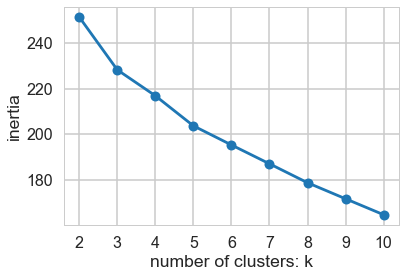

In [7]:
#apply KMeans and get inertia for 2 <= k <= 10
ks = range(2,11)
inertias = [KMeans_inertia(k=k, data=x_cols) for k in ks]

#make plot of inertia vs. k
plt.plot(ks, inertias, marker='.', markersize=20)
plt.xticks(ks)
plt.xlabel('number of clusters: k')
plt.ylabel('inertia')
plt.show()

* Picking K is tough in this instance as their isn't a clear "Elbow" in the plot.  The graph starts to decrease slower at k = 3, but still decreases regularly down to k = 10. 
* There may be an elbow at k = 5 as well.
* I'll say the k = 3 is the elbow.

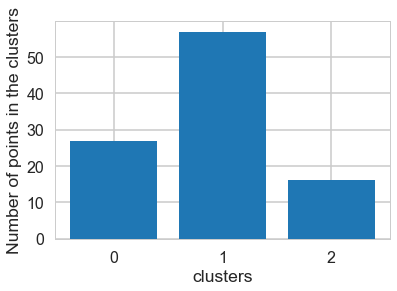

In [8]:
#fit and predict the clusters on the data with Kmeans with 5 clusters
kmeans = KMeans(n_clusters=3, random_state = 42)
matrix['cluster'] = kmeans.fit_predict(x_cols)
counts = matrix.cluster.value_counts()
print()
#plot the number of points in each cluster
plt.bar(matrix.cluster.unique(),counts)
plt.xticks(range(0,matrix.cluster.unique().max() + 1))
plt.xlabel('clusters')
plt.ylabel('Number of points in the clusters')
plt.show()

* The difficulty with elbow method, especially in this case is how to pick the elbow if it is not clearly defined. 
* The result is one cluster with most of the points and two smaller clusters.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.0917487150875


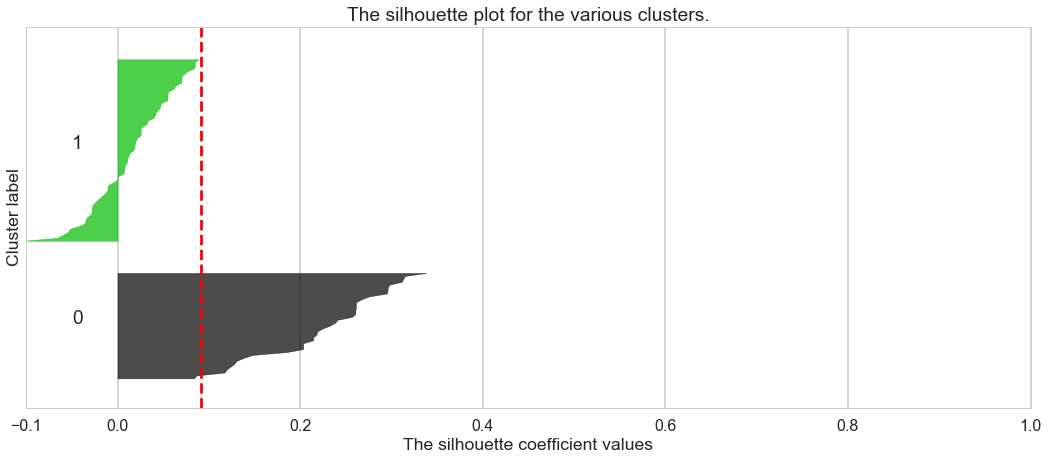

For n_clusters = 3 The average silhouette_score is : 0.115424070379


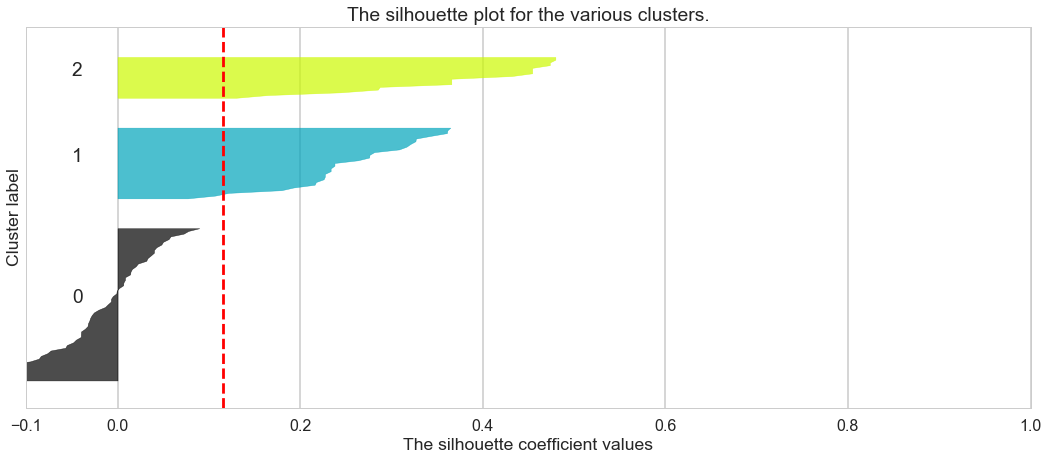

For n_clusters = 4 The average silhouette_score is : 0.0967025836069


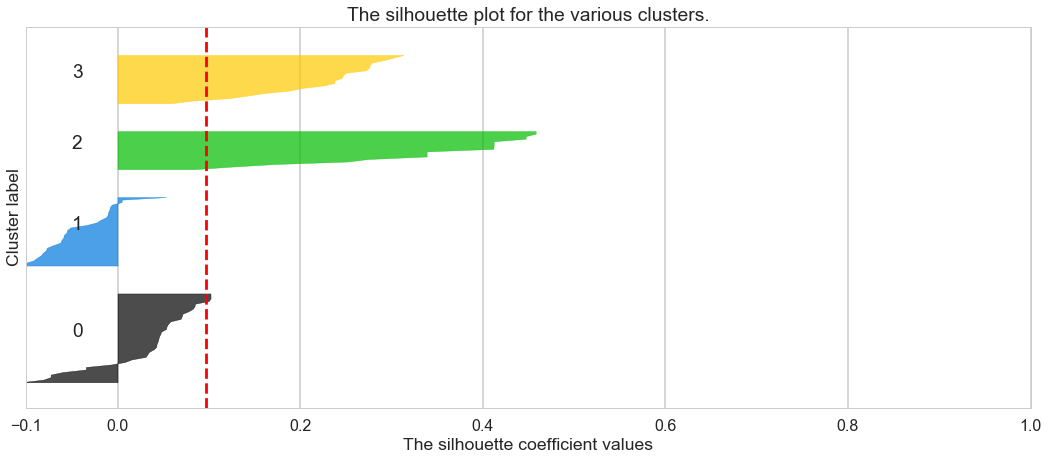

For n_clusters = 5 The average silhouette_score is : 0.145315688203


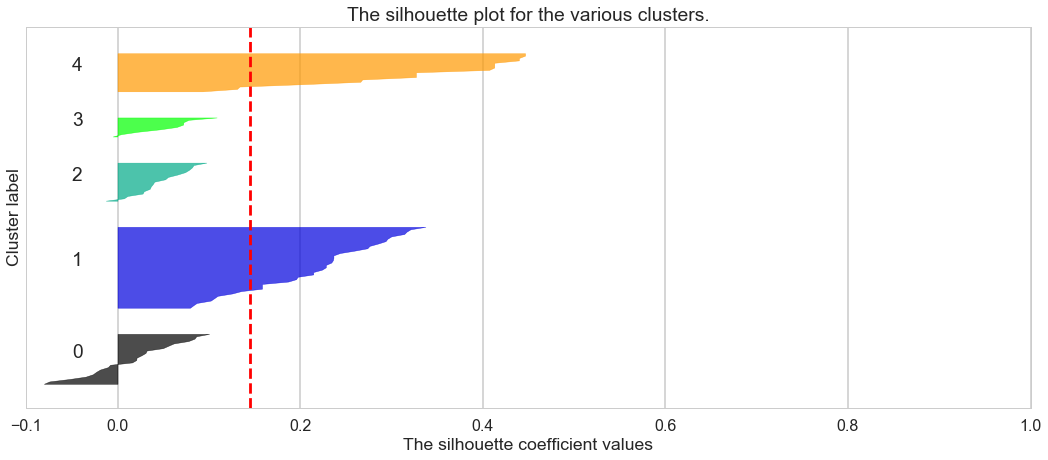

For n_clusters = 6 The average silhouette_score is : 0.133131266271


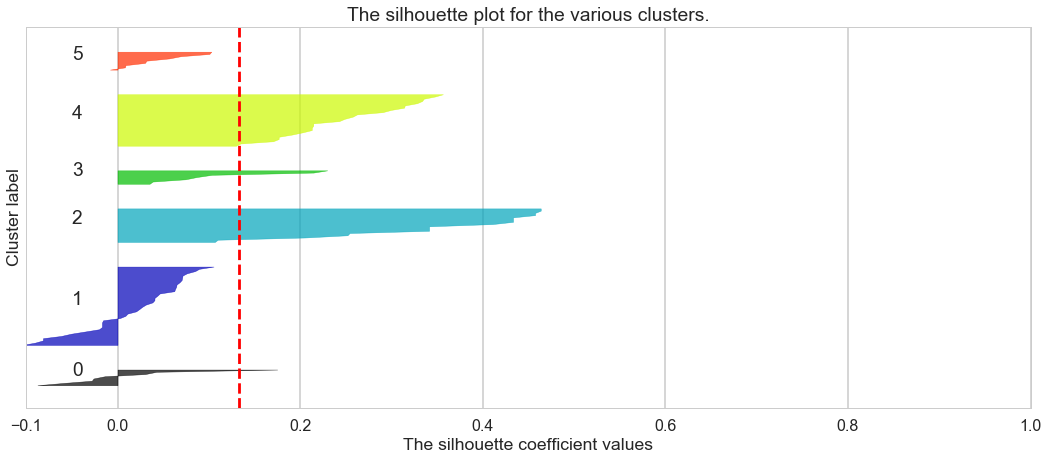

For n_clusters = 7 The average silhouette_score is : 0.130739507718


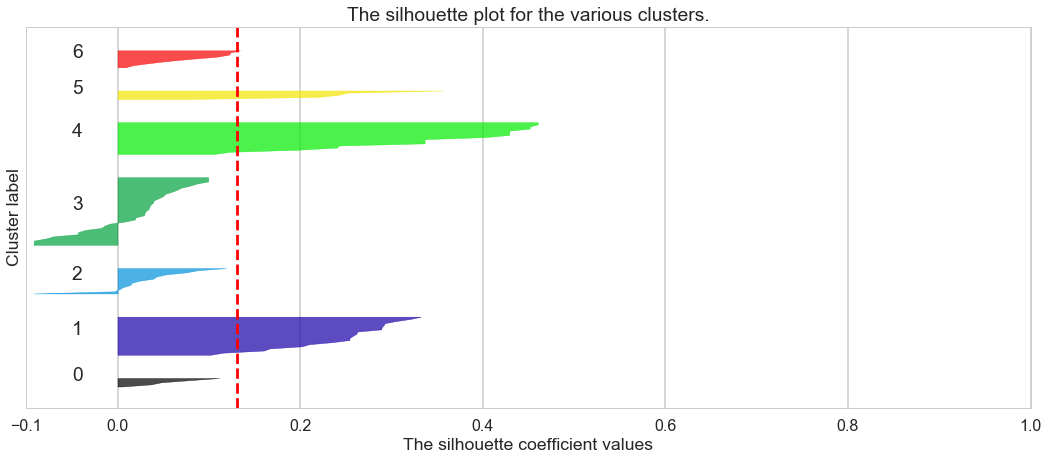

For n_clusters = 8 The average silhouette_score is : 0.123975729011


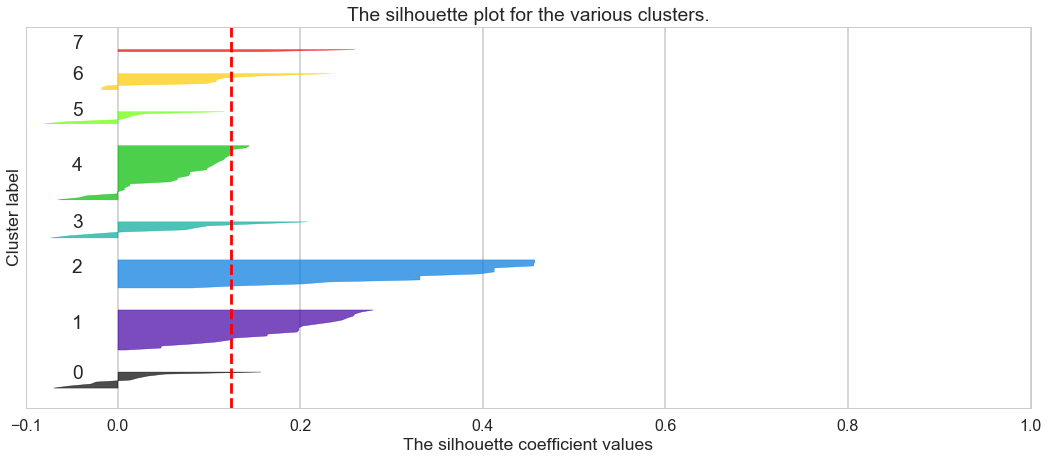

For n_clusters = 9 The average silhouette_score is : 0.120246511094


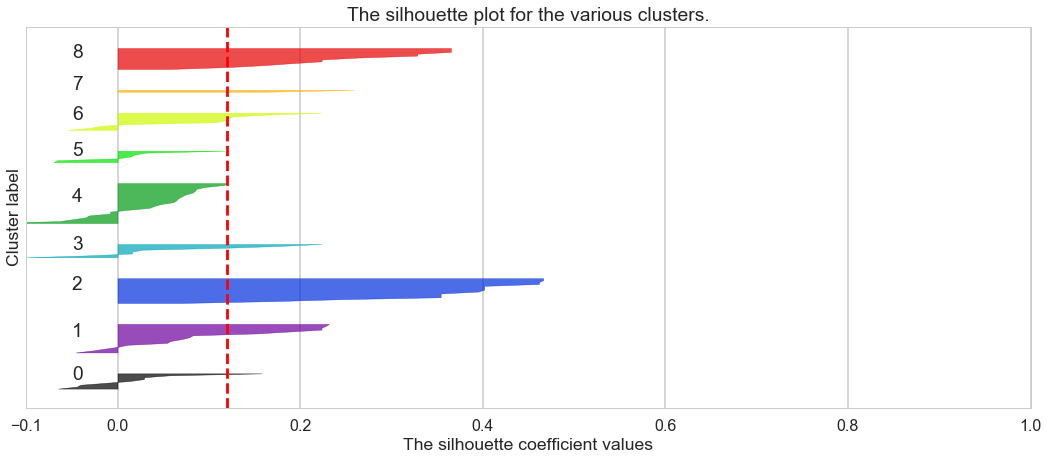

For n_clusters = 10 The average silhouette_score is : 0.126951431234


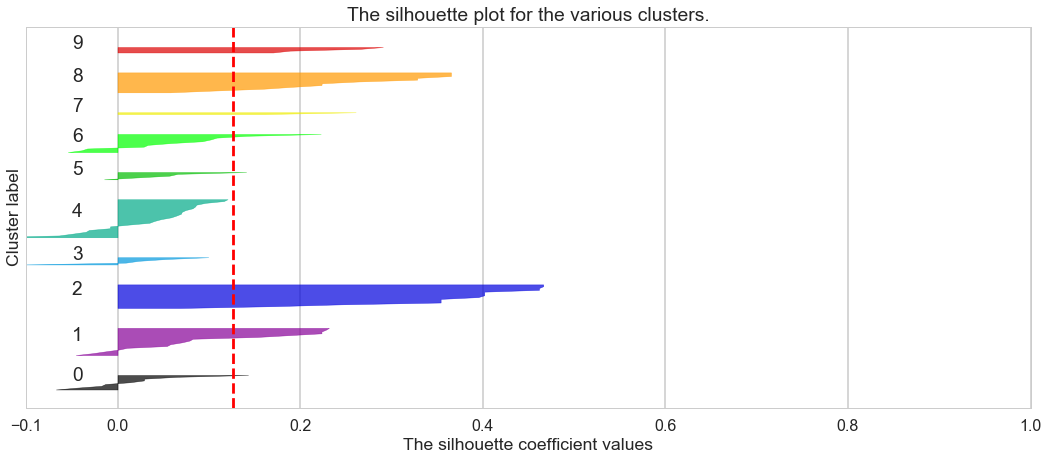

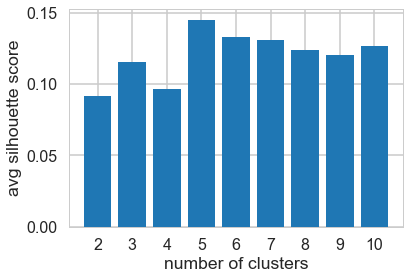

In [9]:
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
#create a silhouette plots for each k value
range_n_clusters = range(2,11)
avgs = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, ax1= plt.subplots(1,1)
    fig.set_size_inches(18, 7)

    # The subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this case they all range from -0.1 to 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    avgs.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()
    
plt.bar(range_n_clusters, avgs)
plt.xlabel('number of clusters')
plt.ylabel('avg silhouette score')
plt.xticks(range(2,11))
plt.show()

* The average silhouette score is highest for k = 5.
* This is a higher value than chosen by the elbow method, and here it's clearer that k = 3 may be the worst choice.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [10]:
#your turn
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

#use PCA on the x_cols data
pca = PCA(n_components=2, random_state=42)
features = pca.fit_transform(x_cols)
print('shape of pca features is {}'.format(features.shape))
print('shape of original data is {}'.format(x_cols.shape))

#create the dataframe
#first get cluster labels for each customer via KMeans n_clusters=5 with the pca features
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(x_cols)
customer_info = pd.DataFrame({'customer_name':matrix['customer_name'], 
                              'cluster_id':clusters, 'x':features[:,0], 'y':features[:,1]})
print(customer_info)

shape of pca features is (100, 2)
shape of original data is (100, 32)
    cluster_id customer_name         x         y
0            1         Adams  1.007580  0.108215
1            0         Allen -0.287539  0.044715
2            4      Anderson -0.392032  1.038391
3            1        Bailey  0.699477 -0.022542
4            0         Baker  0.088183 -0.471695
5            2        Barnes -0.485282 -0.725503
6            4          Bell -0.591941  1.506500
7            1       Bennett  0.661732  0.090308
8            2        Brooks -0.118943 -0.577499
9            1         Brown  1.079827 -0.007488
10           2        Butler -0.240431 -0.617026
11           4      Campbell -0.522247  1.231406
12           1        Carter  1.260763 -0.014255
13           0         Clark -0.579221 -0.420475
14           1       Collins  0.193998  0.010306
15           4          Cook -0.392032  1.038391
16           0        Cooper -0.406276 -0.045771
17           4           Cox -0.591941  1.506500

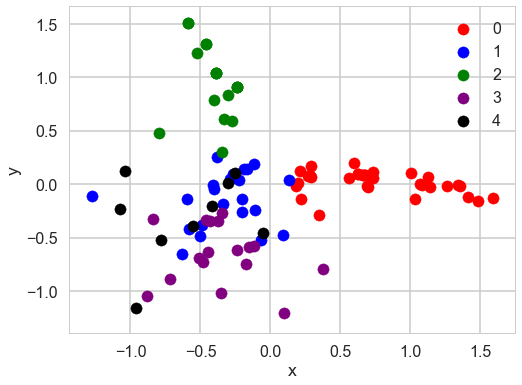

In [11]:
#plot a scatterplot of pca features and color the points by their respective clusters
color = ['red', 'blue', 'green', 'purple', 'black']
plt.figure(figsize=(8,6))
for i, cluster in enumerate(customer_info['cluster_id'].unique()):
    plt.scatter(customer_info.loc[customer_info['cluster_id']==cluster]['x'], 
                customer_info.loc[customer_info['cluster_id']==cluster]['y'], 
                c = color[i], label = i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

* The clusters look forced with lots of overlap.
* 3 clusters might be a good fit, but then one of the clusters would most likely be very large and spread out compared to the other 2 clusters, which might lead to an overall lowering clustering quality.
* I'd say since the elbow method showed a possible elbow at k = 3, it might be the better one in this scenario.  Then again we used pca to reduce the dimensionality of the data and didn't run KMeans with the pca features so this could be a result of smashing dimensions down that is causing the 2D visual overlap.

In [12]:
#now let's take a look at the data behind the clusters.
#first look at the break down of clusters by varietal
cluster_groups = df.merge(customer_info, on='customer_name').drop(['x','y','n','customer_name'], axis=1)
print(cluster_groups.head())
varietals = pd.pivot_table(cluster_groups, index='cluster_id', 
                           columns = ['varietal'], values = 'discount', aggfunc='count').fillna(0)
varietals

   offer_id  campaign    varietal  min_qty  discount  origin  past_peak  \
0         1   January      Malbec       72        56  France      False   
1         4  February   Champagne       72        48  France       True   
2         9     April  Chardonnay      144        57   Chile      False   
3        11       May   Champagne       72        85  France      False   
4        14      June      Merlot       72        64   Chile      False   

   cluster_id  
0           3  
1           3  
2           3  
3           3  
4           3  


varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster_id,,,,,,,,,
0,18.0,29.0,8.0,2.0,2.0,4.0,1.0,2.0,7.0
1,1.0,3.0,0.0,30.0,17.0,6.0,16.0,0.0,19.0
2,6.0,39.0,1.0,8.0,7.0,0.0,0.0,2.0,11.0
3,7.0,9.0,5.0,0.0,4.0,9.0,0.0,2.0,4.0
4,0.0,1.0,1.0,0.0,2.0,1.0,0.0,38.0,2.0


In [13]:
#now let's look at the break down by min qty and discount
min_qtys = cluster_groups.groupby(['cluster_id'])['min_qty','discount'].mean()
min_qtys

,min_qty,discount
cluster_id,,
0,80.219178,67.397260
1,12.717391,55.673913
2,69.081081,61.459459
3,95.550000,59.200000
4,65.866667,51.422222


In [14]:
#now let's try origin 
origins = pd.pivot_table(cluster_groups, index='cluster_id', 
                           columns = ['origin'], values = 'discount', aggfunc='count').fillna(0)
origins

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster_id,,,,,,,,,
0,3.0,6.0,11.0,29.0,5.0,6.0,6.0,5.0,2.0
1,16.0,3.0,7.0,35.0,0.0,0.0,1.0,14.0,16.0
2,5.0,3.0,6.0,42.0,4.0,2.0,3.0,6.0,3.0
3,2.0,2.0,13.0,13.0,0.0,4.0,2.0,1.0,3.0
4,13.0,2.0,0.0,9.0,7.0,12.0,1.0,0.0,1.0


In [15]:
#by past peak or not
peaks = pd.pivot_table(cluster_groups, index='cluster_id', 
                           columns = ['past_peak'], values = 'discount', aggfunc='count').fillna(0)
peaks

past_peak,False,True
cluster_id,,
0,52.0,21.0
1,75.0,17.0
2,60.0,14.0
3,35.0,5.0
4,45.0,0.0


* Observational summaries about the data clusters
    * Most customers on the whole prefer wine that is not past its peak.
    * Customers in clusters 0, 2, 3, and 4 like to buy their wine bulk on average when compared to cluster 1.
    * The majority of the customers in clusters 0, 1, and 2 seem to prefer french wine and the other clusters also have a healthy affinity for french wine.
    * Probably safe in offering discounts on austrailian and french wine to any customer group.
    * Customers in clusters 0 and 2 really like their Champagne.
    * Customers in cluster 4 seem to only want Pinot Noir.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

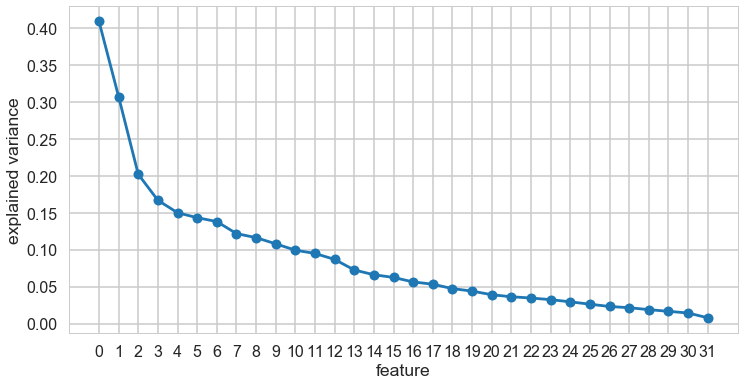

In [16]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA(random_state=42)
pca.fit(x_cols)

# Do the rest on your own :)
plt.figure(figsize=(12,6))
plt.plot(range(pca.n_components_), pca.explained_variance_, marker='.', markersize=20)
plt.xlabel('feature')
plt.ylabel('explained variance')
plt.xticks(range(pca.n_components_))
plt.show()

* It appears that the intrinsic number of dimensions could be around 3 or 4.  I'll say 3 dimensions intrinsically based on this plot.

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


Estimated number of clusters: 14
Silhouette Coefficient: 0.12346523604478911


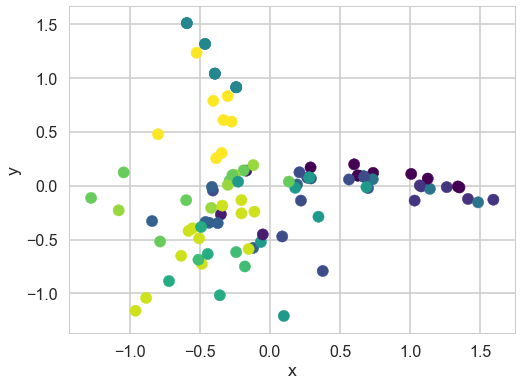

In [17]:
# Your turn
#1. Affinity propagation
# Compute Affinity Propagation
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

x = customer_info['x']
y = customer_info['y']

af = AffinityPropagation().fit(x_cols)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: {}'.format(n_clusters_))
print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(x_cols, labels)))

#create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, c= labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Silhouette Coefficient: 0.015856768776882108


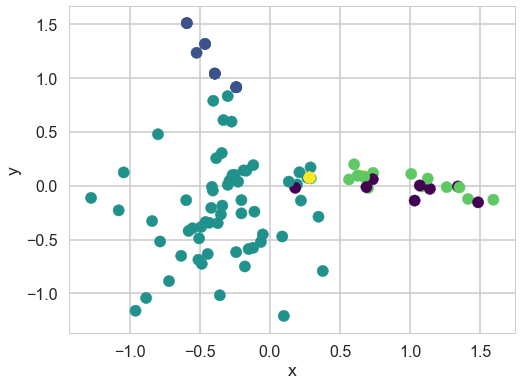

In [18]:
#2. Spectral Clustering
#choose 5 clusters again for scoring comparison with KMeans
from sklearn.cluster import SpectralClustering
spec = SpectralClustering(n_clusters=5, random_state=42)
spec.fit(x_cols)
labels = spec.labels_
print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(x_cols, labels)))

#create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, c= labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Silhouette Coefficient: 0.14089739970831974


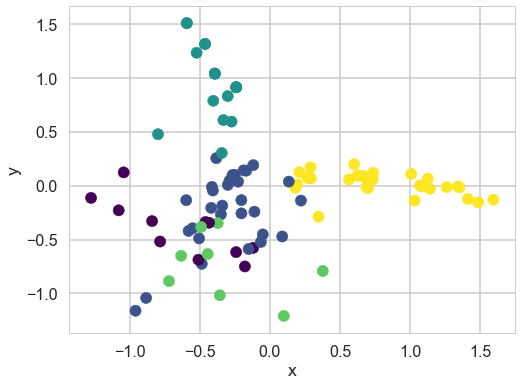

In [19]:
#3. Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5)
agg.fit(x_cols)
labels = agg.labels_
print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(x_cols, labels)))

#create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, c= labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Silhouette Coefficient: 0.03831616142184094


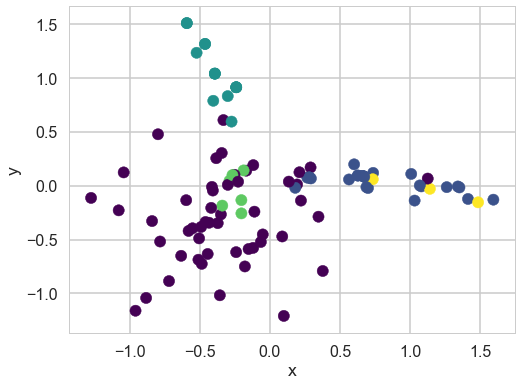

In [20]:
#4. DBSCAN
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, min_samples=3)
labels = dbscan.fit_predict(x_cols)
print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(x_cols, labels)))

#create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, c= labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Silhouette Coefficient: 0.06989092177066446


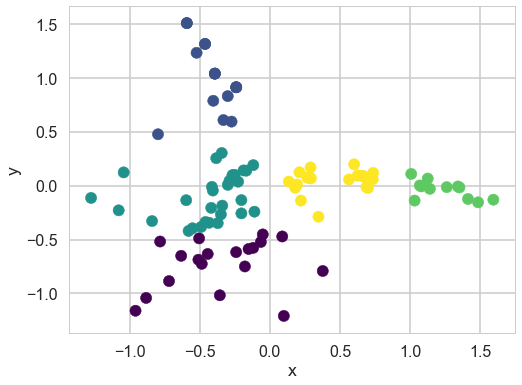

In [21]:
#5. Try KMeans with the PCA features as the data to cluster with n_clusters=5
kmeans = KMeans(n_clusters=5)
labels = kmeans.fit_predict(features)
print('Silhouette Coefficient: {}'.format(metrics.silhouette_score(x_cols, labels)))

#create scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x, y, c= labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

* KMeans for n_clusters = 5 The average silhouette_score is : 0.145315688203.
* None of the new methods had better silhouette scores.
* Affinity propagation create 14 clusters which created a lot of mixed clusters that certainly overlap.
    * Although it seemed to cluster the champagne drinkers together.
* Spectral clustering created one big spread out cluster with smaller overlapping sattelites.
    * Uneven cluster size could have had a negative effect on this algorithms performance.
* The default Agglomerative Clustering algorithm performed almost as well as the KMeans with 5 clusters.
    * The scatter plots show that the grouping is very similar as well.
    * Clustering the champagne together
    * It seems to have grouped the champagne and cab drinkers together as well who don't mind buying wine past its peak sometimes.  They also like to buy in bulk.
    * It also seems to have clustered the group who goes for low quantity offers.
* DBSCAN performed poorly showing groups within groups and major overlap among the clusters.
    * Having one large spread out cluster as well.  
    * This algorithm may have performed so poorly in this use case due to the low number of samples and the low number of clusters.  The sparse dataset means that a lot of the points are seen as noise with this model.
* Using the top 2 pca features for KMeans with 5 clusters has a low silhouette score but a prettier scatter plot in 2 dimensions which makes sense since we reduced the data down to 2D before clustering.  However, the score shows that we lost a lot of information in the data by doing so.
* Boiling the other clusterings down to 2D plots is a little misrepresentative of the actual clustering in higher dimensions which is very difficult to visualize.
* It seems that there is no rigid cubby holes to cluster customers into.  There are patterns that are present, but people sometimes go for the cheapest discount no matter the min order or to only go for the min order to save upfront money regardless of wine type, origin, etc.  Then others like certain types of wine and only choose those offers regardless of the other offer details etc.